# 链接仪器

In [1]:
%matplotlib notebook
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt, seaborn as sns
import numpy as np, sympy as sy, visa
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys, imp, pandas as pd
from tqdm import tqdm_notebook as tqdm
# from easydl import clear_output
from sklearn.cluster import KMeans
# from qulab import wavepoint
# from qulab import optimize, measureroutine, computewave, imatrix, waveform_new
# from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho
from qulab.math import opt
from qulab import ezQ
from qulab import computewave_ztw, waveform, optimize
from qulab import simpletes
sim = imp.reload(simpletes)
op = imp.reload(optimize)
cw = imp.reload(computewave_ztw)
ezQ = imp.reload(ezQ)
wn = imp.reload(waveform)

Log file path: D:\QuLab\qulab\log\test\test.log


# 设置参数

In [2]:
depth = 1500
trig_count = 1000
trig_interval = 260e-6
f_mix = [80e6,0,0,0,0,0,0,0]
amp = 32767.5  # 避免越界，比32768略小
# ad_trig_delay = 0
ad_trig_delay = 90354e-9 #s 出发
t_list = np.linspace(0,30000,60001)*1e-9

psg_lo = await connect('PSG27')
psg_ex = await connect('PSG28')
psg_pump = await connect('PSG25')

# att3 = await connect('Att3')
# att4 = await connect('Att4')
# att5 = await connect('Att5')
# att6 = await connect('Att6')

dcch1 = ezQ.DC('DC1','10.0.200.72',5000,1)
dcch2 = ezQ.DC('DC1','10.0.200.72',5000,2)
dcch3 = ezQ.DC('DC1','10.0.200.72',5000,3)
dcch4 = ezQ.DC('DC1','10.0.200.72',5000,4)


awg1 = ezQ.DA('QF10K4N0050', '10.0.200.68','QF10K4N0050', '10.0.200.68')
awg2 = ezQ.DA('QF10K4N0075', '10.0.200.70','QF10K4N0050', '10.0.200.68')#XYA,XYB
awg3 = ezQ.DA('QF10K4N0064', '10.0.200.69','QF10K4N0050', '10.0.200.68')#XYC,XYD
awg4 = ezQ.DA('QF10K4N0034', '10.0.200.71','QF10K4N0050', '10.0.200.68')

ad = ezQ.AD('QE10K4N0016', '00-00-00-00-00-60', "B4-96-91-78-AB-0E")

dc = {
    'q1':dcch1,
    'q2':dcch2,
    'q3':dcch3,
    'q4':dcch4,
    'q5':dcch1,
    'q6':dcch2,
    'q7':dcch3,
    'q8':dcch4,
    'q9':dcch1,
    'q10':dcch2,
    'jpa':dcch3,
}

psg = {
    'psg_lo':psg_lo,
    'psg_ex':psg_ex,
    'psg_trans':psg_lo,
    'psg_pump':psg_pump
}

awg = {'awg1':awg1,
       'awg2':awg2, 
       'awg3':awg3,
       'awg4':awg4
      }


In [3]:
def resn(f_list):
    f_list = np.array(f_list)   #readout frequency 
    f_lo = f_list.max() - 80e6    #readout LO frequency
    delta =  -(f_lo - f_list)      #readout carry frequency
    n = len(f_list)
    return f_lo, delta, n
f_list = np.array([6.53,6.542,6.558,6.569,6.587,6.600,6.6045,6.628])*1e9
f_lo, delta, n = resn(f_list)

In [4]:
qubit_list = {'Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10'}

In [45]:
type(q4.inst['dc'])

str

In [5]:
attribute = ['q_name',
             'inst',
             'T_bias',
             'specfunc', 
             'bias', 
             'zpulse', 
             'f_lo', 
             'delta',
             'f_ex',
             'delta_ex',
             'alpha', 
             'power_ex',
             'power_rabi',
             'pi_len', 
             'T1',
             'state',
             'timing'
            ]

qubit = namedtuple('qubit',attribute,defaults=[None]*len(attribute))

q4 = qubit(
    q_name='q4',
    inst={'dc':'dcch2',
          'z_awg':'awg4', 
          'z_ch':4,
          'lo_awg':'awg1',
          'lo_ch':[1,2],
          'ex_awg':'awg2',
          'ex_ch':[3,4],
          'psg_lo':'psg_lo',
          'att':'att4'
         },
    f_lo=np.array([6.542e9]), 
    delta=np.array([50e6]), 
    bias=0.1, 
    zpulse=None,
    f_ex=np.array([3.7e9]), 
    delta_ex=np.array([200e6]),pi_len=20)
q5 = qubit(
    q_name='q5', 
    inst={'dc':'dcch2',
          'z_awg':'awg4',
          'z_ch':1,
          'lo_awg':'awg1',
          'lo_ch':[1,2],
          'ex_awg':'awg3',
          'ex_ch':[1,2],
          'psg_lo':'psg_lo',
          'att':'att5'},
     f_lo=np.array([6.5048e9]),
    delta=np.array([50e6]),
    bias=0.1, 
    zpulse=None,
    f_ex=np.array([3.884e9]), 
    delta_ex=np.array([200e6]),
    pi_len=126)
q6 = qubit(
    q_name='q6',
        inst={'dc':'dcch3',
             'z_awg':'awg4',
             'z_ch':2,
             'lo_awg':'awg1',
             'lo_ch':[1,2], 
              'ex_awg':'awg2',
             'ex_ch':[3,4],
              'psg_lo':'psg_lo',
              'att':'att6'},
    f_lo=np.array([6.569e9]), 
    delta=np.array([50e6]),
    bias=0.1, 
    zpulse=None,
    f_ex=np.array([3.7e9]),
    delta_ex=np.array([200e6]),
    pi_len=20)
q7 = qubit(
    q_name='q7',
    inst={'dc':'dcch4',
          'z_awg':'awg4',
          'z_ch':3,
          'lo_awg':'awg1',
          'lo_ch':[1,2],
          'ex_awg':'awg3',
          'ex_ch':[3,4],
          'psg_lo':'psg_lo',
          'att':'att4'},
    f_lo=np.array([6.530e9]),
    delta=np.array([50e6]),
    bias=0.1, 
    zpulse=None,
    f_ex=np.array([3.7e9]), 
    delta_ex=np.array([200e6]),
    pi_len=20)

In [6]:
f_cavity = 6.53e9
jpa=None
qubits=[q4,q5,q6,q7]
measure = sim.common(f_cavity,ad,dc,psg,awg,jpa,qubits)
measure.readlen = depth
# measure.delta = delta
measure.mode = 1
measure.f_list = f_list
measure.f_lo = f_lo
measure.depth = 1500
measure.trig_count = 1000
measure.trig_interval = trig_interval

## 设备设置

### 链接仪器

In [13]:
for i in measure.awg:
    measure.awg[i].da_connect_device()
measure.ad.ad_connect_device()

da board:[QF10K4N0050] connect success .
da board:[QF10K4N0075] connect success .
da board:[QF10K4N0064] connect success .
da board:[QF10K4N0034] connect success .
B4-96-91-78-AB-0E 00-00-00-00-00-60


['频率(MHz)：79.99998331069946', '频率(MHz)：0.0', '频率(MHz)：0.0', '频率(MHz)：0.0', '频率(MHz)：0.0', '频率(MHz)：0.0', '频率(MHz)：0.0', '频率(MHz)：0.0']
['解模长度：1000', '解模长度：1500', '解模长度：1500', '解模长度：1500', '解模长度：1500', '解模长度：1500', '解模长度：1500', '解模长度：1500']
['解模窗口：1500', '解模窗口：1500', '解模窗口：1500', '解模窗口：1500', '解模窗口：1500', '解模窗口：1500', '解模窗口：1500', '解模窗口：1500']
['解模起始：0', '解模起始：0', '解模起始：0', '解模起始：0', '解模起始：0', '解模起始：0', '解模起始：0', '解模起始：0']
['态判断参数A：0', '态判断参数A：0', '态判断参数A：0', '态判断参数A：0', '态判断参数A：0', '态判断参数A：0', '态判断参数A：0', '态判断参数A：0']
['态判断参数B：0', '态判断参数B：0', '态判断参数B：0', '态判断参数B：0', '态判断参数B：0', '态判断参数B：0', '态判断参数B：0', '态判断参数B：0']
['态判断参数C1：0', '态判断参数C1：0', '态判断参数C1：0', '态判断参数C1：0', '态判断参数C1：0', '态判断参数C1：0', '态判断参数C1：0', '态判断参数C1：0']
['态判断参数C2：0', '态判断参数C2：0', '态判断参数C2：0', '态判断参数C2：0', '态判断参数C2：0', '态判断参数C2：0', '态判断参数C2：0', '态判断参数C2：0']
已收到的触发个数：1000
已完成触发解模个数：1000
上位机读分段长度：80
AD 触发自适应状态：未完成xxx
SRAM校准状态：AD SRAM校准完成
上位机读取模式状态：上位机读取模式
IQ数据源状态：使用真实IQ数据
SRAM数据源状态：使用真实数据
解模DDS数据源：使用DDS IP生成数据
上位机读起始地址 单位 8字节：

0

### 仪器初始化

In [14]:
#初始化
for i in measure.awg:
    measure.awg[i].da_init_device(trig_interval)
    measure.awg[i].da_trigg(trig_count)
measure.ad.ad_init_device()
#采集数据出发时间延迟
awg1.da_set_trig_delay(ad_trig_delay)#AWG主板
measure.ad.set_ad(depth, trig_count, mode=1)
measure.ad.ad_data_clear()
measure.ad.set_ad_freq(f_mix, depth, window_start=8)

Trig_delay should be a multiple of 4ns,otherwise we'll round it up.In this case,the real value of trig_delay is 90356ns
Width+trig_delay should be a multiple of 4ns,otherwise we'll round it up.In this case,the real value of width+trig_delay is 90392ns


1000
da board:[QE10K4N0016] set param success .


0

# 仪器和信号检查

## 时域信号

In [30]:
I, Q = cw.modulation_read(q4, measure,[80e6],readlen=1000)

In [40]:
%matplotlib notebook
q_target = q4
tag = q_target.q_name
# ezQ.Att_Setup(measure,'com3').Att(0)
I, Q = 0, 0
await psg['psg_lo'].setValue('Output','ON')
await psg['psg_ex'].setValue('Output','OFF')
await psg['psg_lo'].setValue('Frequency',6e9)
for i in range(1):
    chA, chB = ezQ.getTraces(q_target,measure,avg=True,hilbert=False,is2ch=False)
    I += chA
    Q += chB

<IPython.core.display.Javascript object>


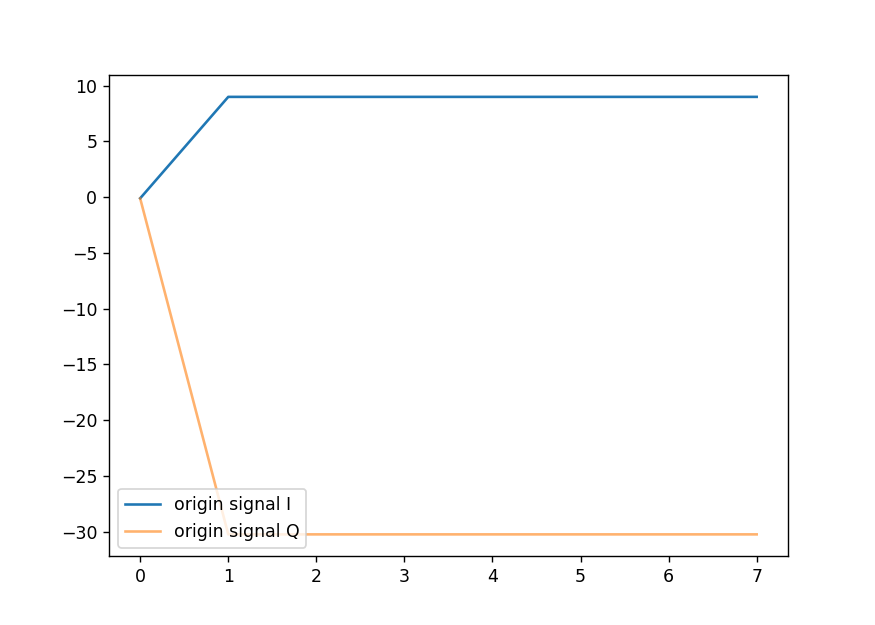

In [41]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(len(I)), I,label='origin signal I')
plt.plot(np.arange(len(Q)), Q,label='origin signal Q',alpha=0.6)
#plt.plot(np.arange(len(Q)), np.sqrt(I**2+Q**2),'.',label='envelop')
plt.legend(loc="lower left")
plt.show()

<IPython.core.display.Javascript object>


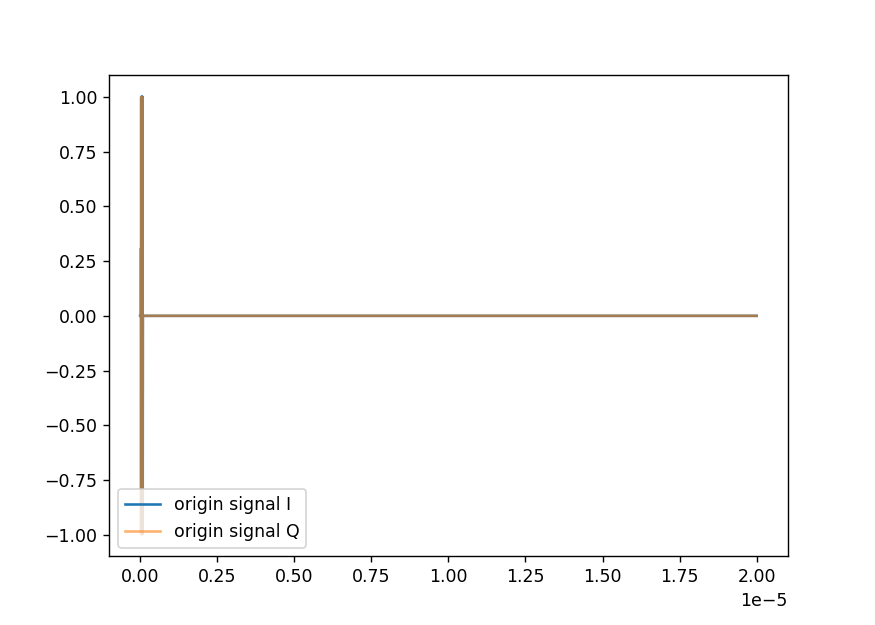

In [42]:
t_list = np.linspace(0,20000,40001)*1e-9
during = 55/1e9
pulse = ((wn.square(during) >> (during))) 
wav_I, wav_Q = wn.mixing(pulse, phase=0,freq=80e6, ratioIQ=-1.0)
I,Q = wav_I(t_list), wav_Q(t_list)
plt.figure(figsize=(7,5))
plt.plot(t_list, I,label='origin signal I')
plt.plot(t_list, Q,label='origin signal Q',alpha=0.6)
#plt.plot(np.arange(len(Q)), np.sqrt(I**2+Q**2),'.',label='envelop')
plt.legend(loc="lower left")
plt.show()

## 频域信号

<IPython.core.display.Javascript object>


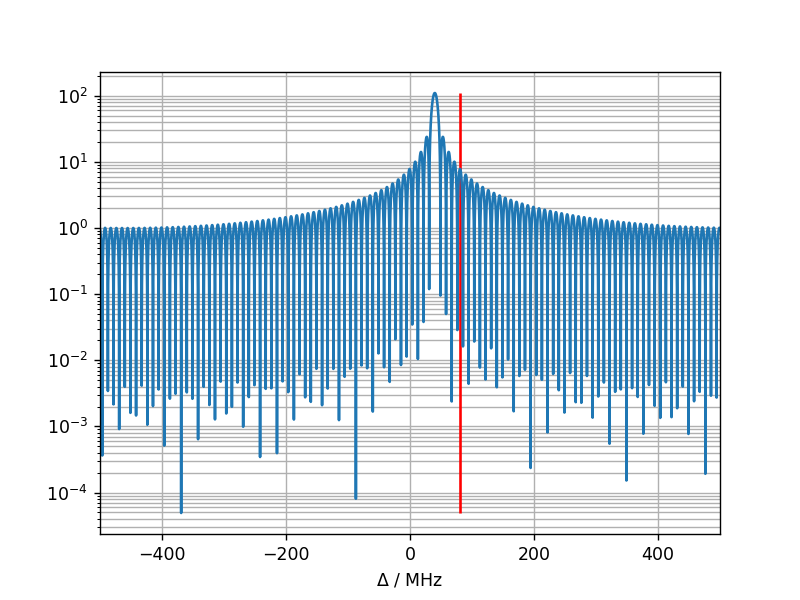

In [43]:
x = np.fft.fftshift(np.fft.fftfreq(len(I)))*1e9
y = np.fft.fftshift(np.fft.fft(I + 1j*Q))
Delta_list = 80e6
plt.figure()

plt.vlines(Delta_list/1e6, np.min(np.abs(y)), np.max(np.abs(y)), 'r')

plt.semilogy(x/1e6, np.abs(y))

plt.grid(which='both')
plt.xlabel(r'$\Delta$ / MHz')
plt.xlim(-500,500)
plt.show()

## 仪器出错情况

In [ ]:
for i in range(100): 
    await psg_ex.query('syst:err?')

In [ ]:
await psg_lo.query('syst:err?')

# S21

In [19]:
calimatrix=np.array([[1.        , 0.30428838, 0.22015648],
        [1.25005212, 1.        , 0.2864555 ],
        [2.81407692, 0.43015039, 1.        ]])
I0 = np.array([[ 0.98222284],
        [-0.42383087],
        [ 0.22771331]])

In [20]:
calimatrix = np.mat(calimatrix)
I = calimatrix.I*np.mat([0,1,0]).T+I0
I

matrix([[0.11088962],
        [1.1578906 ],
        [1.9993339 ]])

In [31]:
# measure.dc[q6.q_name].dc(1.58029)
measure.dc[q6.q_name].dc(-2)

In [21]:
freqall = np.array([6.505,6.518,6.53,6.542,6.557,6.568,6.587,6.601,6.6045,6.628])*1e9

Output()

<IPython.core.display.Javascript object>


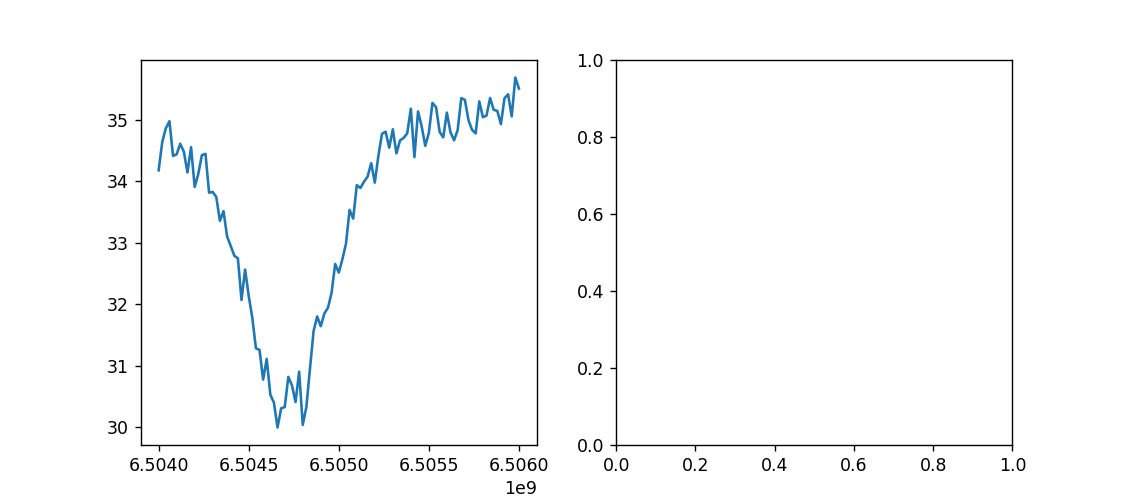

In [22]:
q_target = q6
tag = q_target.q_name
await psg['psg_lo'].setValue('Output','ON')
await psg['psg_ex'].setValue('Output','ON')

freq = freqall[0]  + np.linspace(-1e6,1e6,101)-80e6

# await att3.set_att(20)
job = Job(sim.S21, (q_target,measure,freq),auto_save=True,max=126,tags=[q_target.q_name])
f_s21, s_s21 = await job.done()
%matplotlib notebook
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,20*np.log10(np.abs(s_s21)))
# axes[0].vlines(f_lo-delta,np.max(20*np.log10(np.abs(s_s21))),np.min(20*np.log10(np.abs(s_s21))),'r')
# axes[1].vlines(f_lo-delta,np.max(np.angle(s_s21)),np.min(np.angle(s_s21)),'r')
# axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

In [24]:
q6

(101,)

In [174]:
q6 = q6._replace(f_lo =np.array([6.5682e9]))

# S21vsFlux

In [355]:
q_target = q6
tag = q_target.q_name
await psg['psg_lo'].setValue('Output','ON')
await psg['psg_ex'].setValue('Output','ON')

#await att3.set_att(16)
currrent = np.linspace(-6,6,21)
freq = freqall[5]  + np.linspace(-1,1,21)*2.5e6-80e6

job = Job(sim.S21vsFlux, (q_target,measure,currrent,freq),auto_save=True,max=len(currrent),tags=[q_target.q_name])
c_s21, f_s21, s_s21 = await job.done()

Output()

In [214]:
np.shape(f_s21[:,:,]),np.shape(c_s21[:,]),np.shape(s_s21[:,])

((41, 21, 1), (41, 1), (41, 21))

In [218]:
f_s21[:,:,0][0],

array([6.56550e+09, 6.56575e+09, 6.56600e+09, 6.56625e+09, 6.56650e+09,
       6.56675e+09, 6.56700e+09, 6.56725e+09, 6.56750e+09, 6.56775e+09,
       6.56800e+09, 6.56825e+09, 6.56850e+09, 6.56875e+09, 6.56900e+09,
       6.56925e+09, 6.56950e+09, 6.56975e+09, 6.57000e+09, 6.57025e+09,
       6.57050e+09])

<IPython.core.display.Javascript object>


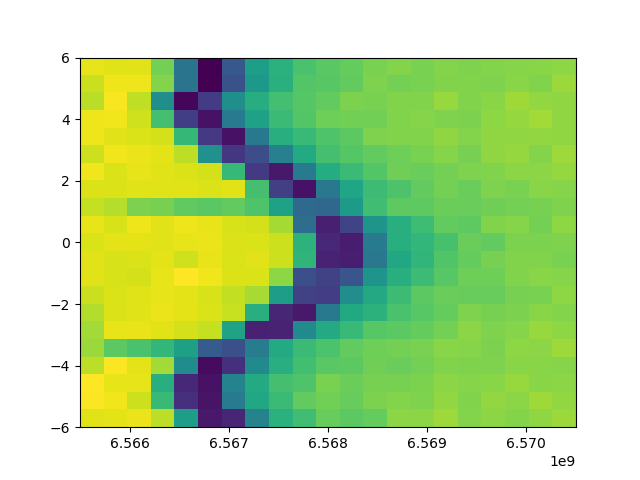

In [356]:
plt.figure()
plt.imshow(abs(s_s21),aspect=('auto'),origin = ('lower'),extent=(min(freq)+80e6,max(freq)+80e6,min(currrent),max(currrent)))

In [179]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=<deprecated parameter>, filternorm=1, filterrad=4.0, imlim=<deprecated parameter>, resample=None, url=None, *, data=None, **kwargs)
    Display data as an image; i.e. on a 2D regular raster.
    
    The input may either be actual RGB(A) data, or 2D scalar data, which
    will be rendered as a pseudocolor image. Note: For actually displaying
    a grayscale image set up the color mapping using the parameters
    ``cmap='gray', vmin=0, vmax=255``.
    
    Parameters
    ----------
    X : array-like or PIL image
        The image data. Supported array shapes are:
    
        - (M, N): an image with scalar data. The values are mapped to
          colors using normalization and a colormap. See parameters *norm*,
          *cmap*, *vmin*, *vmax*.
        - (M, N, 3): an image with RGB values (0-1 float or 

<IPython.core.display.Javascript object>


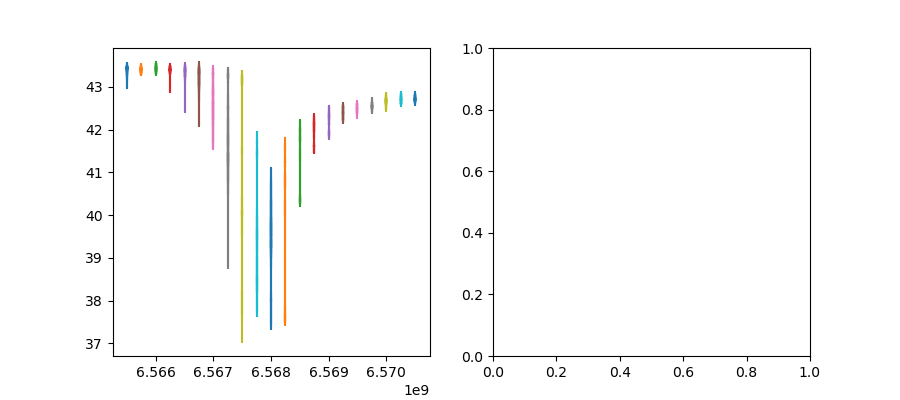

In [213]:
%matplotlib notebook
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21[:,:,0],20*np.log10(np.abs(s_s21)))
# axes[0].vlines(f_lo-delta,np.max(20*np.log10(np.abs(s_s21))),np.min(20*np.log10(np.abs(s_s21))),'r')
# axes[1].vlines(f_lo-delta,np.max(np.angle(s_s21)),np.min(np.angle(s_s21)),'r')
# axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

<IPython.core.display.Javascript object>


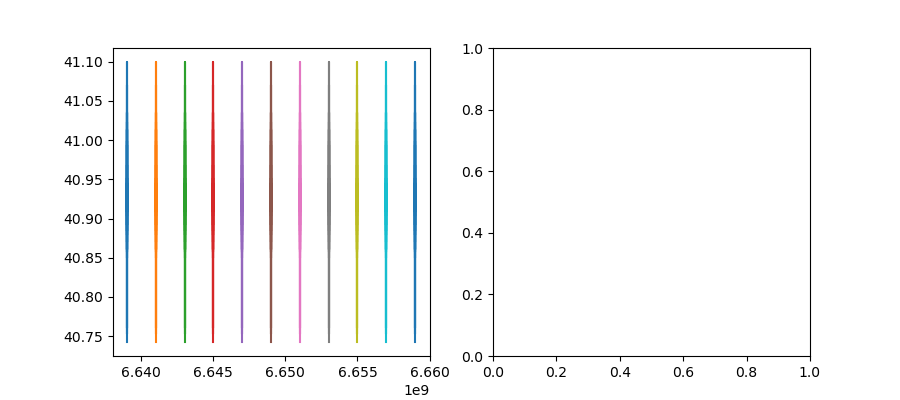

In [189]:
%matplotlib notebook
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21[:,:,0],20*np.log10(np.abs(s_s21[:,0])))
# axes[0].vlines(f_lo-delta,np.max(20*np.log10(np.abs(s_s21))),np.min(20*np.log10(np.abs(s_s21))),'r')
# axes[1].vlines(f_lo-delta,np.max(np.angle(s_s21)),np.min(np.angle(s_s21)),'r')
# axes[1].plot(f_s21[:,:,0],np.angle(s_s21))
plt.show()

# S21vsPower

In [14]:
q_target, att = q3, np.linspace(0,40,81)
tag = q_target.q_name
#await psg[q_target.inst['ex_lo']].setValue('Output','OFF')
job = Job(ezQ.S21vsPower, (q_target,measure,att,'com3',True), tags=[tag], max=len(att))
att_p, f_p, s_p = await job.done()

Output()

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_p[0][:,0]),np.max(f_p[0][:,0]),np.min(att_p[:,0]),np.max(att_p[:,0])]
axes[0].imshow(np.abs(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
axes[1].imshow(np.angle(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
plt.show()

# singlespec

In [41]:
dcch2.dc(-0.4)
dcch4.dc(0.4)

In [360]:
await measure.psg['psg_ex'].setValue('Power',0)
await measure.psg['psg_lo'].setValue('Power',21)

Output()

<IPython.core.display.Javascript object>


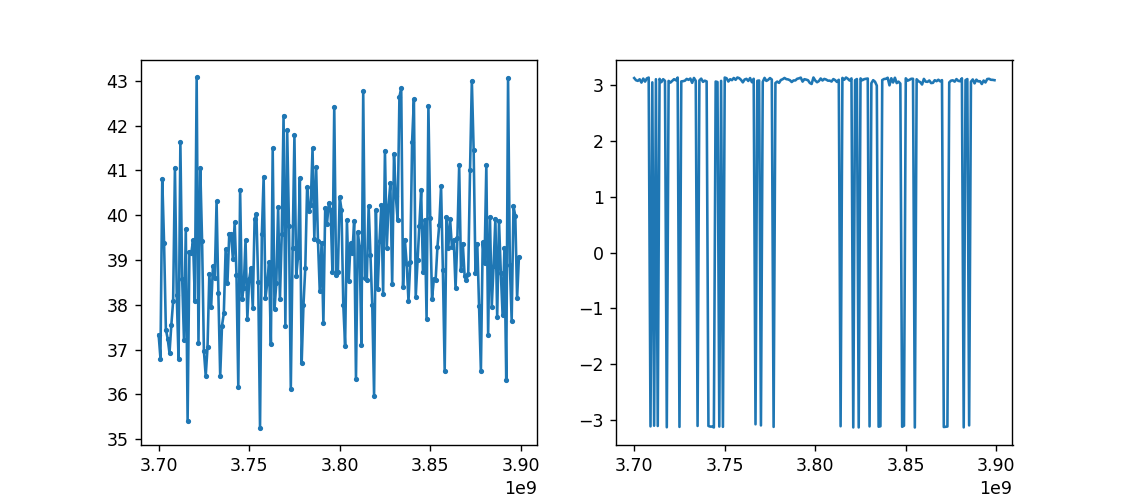

In [24]:
q_target = q5
# readponit = 6.5575
readponit = 6.5048e9
tag = q_target.q_name
measure.dc[q5.q_name].dc(1.2)
await measure.psg['psg_ex'].setValue('Power',-8)
# await att6.set_att(10)
# ret = cw.z_pulse(q6,measure,width=30000,amp=0)
# await measure.psg['psg_ex'].setValue('Output','ON')
ex_freq = np.arange(3.7,3.9,0.001)*1e9
# await measure.psg['psg_lo'].setValue('Frequency',f_lo)
%matplotlib notebook
job = Job(sim.singlespec, (q_target, measure ,readponit, ex_freq), tags=[tag], max=len(ex_freq))
f_ss, s_ss = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_ss,np.abs(s_ss),'-o',markersize=2)
# axes[0].plot(x,z)
# axes[0].set_title(f'f={np.array(band)[:,0]}GHz')
#print(band)
axes[1].plot(f_ss,np.angle(s_ss))
plt.show()

In [35]:
index = np.abs(s_ss).argmax(axis=0)
f_ex = f_ss[index]
q6 = q6._replace(f_ex = np.array([f_ex[0]]))

In [36]:
f_ex[0]

3883999999.99998

In [325]:
f_ex[0]

3637999999.9999957

In [334]:
f_ex[0]

3958999999.9999604

In [14]:
q6 = q6._replace(f_ex = np.array([3954999999.9999886+0.64e6]))

In [205]:
q6.f_ex-q6.delta_ex

array([3.733e+09])

In [10]:
measure.base = 0
measure.n = 8

<IPython.core.display.Javascript object>


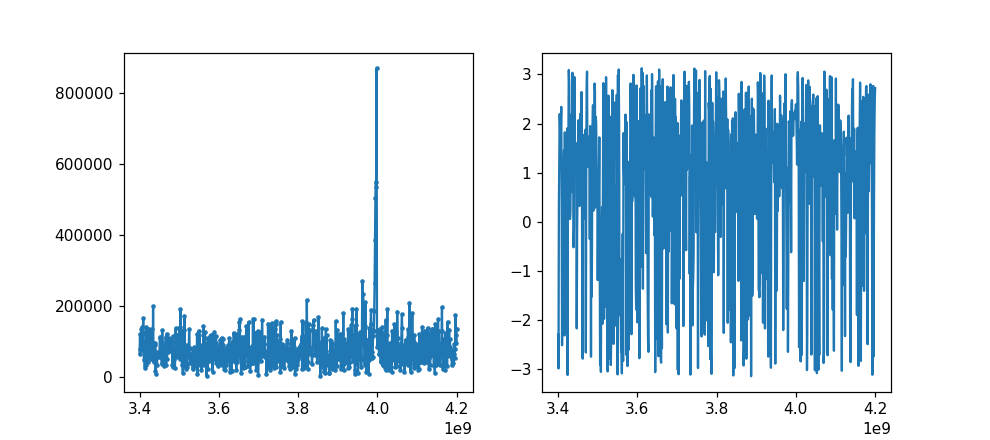

In [49]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_ss[:,0],np.abs(s_ss[:,0]),'-o',markersize=2)
# axes[0].plot(x,z)
# axes[0].set_title(f'f={np.array(band)[:,0]}GHz')
#print(band)
axes[1].plot(f_ss[:,0],np.angle(s_ss[:,0]))
plt.show()

<IPython.core.display.Javascript object>


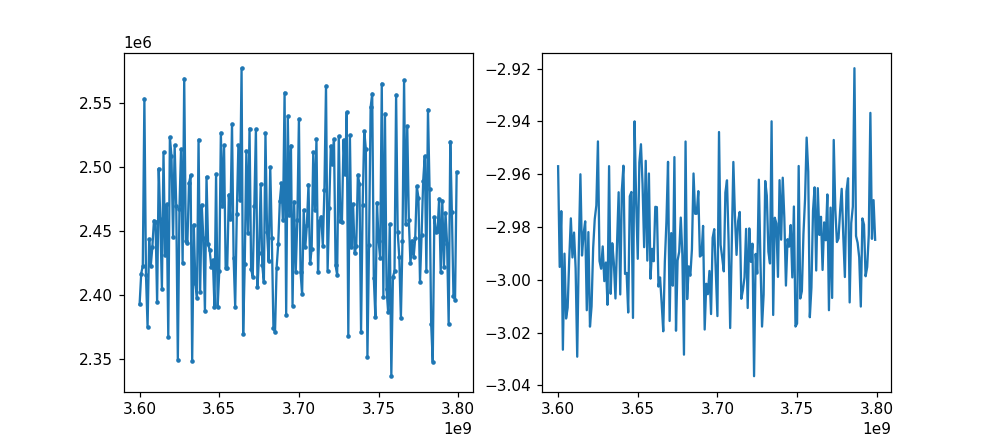

In [17]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_ss[:,0],np.abs(s_ss[:,0]),'-o',markersize=2)
# axes[0].plot(x,z)
# axes[0].set_title(f'f={np.array(band)[:,0]}GHz')
#print(band)
axes[1].plot(f_ss[:,0],np.angle(s_ss[:,0]))
plt.show()

<IPython.core.display.Javascript object>


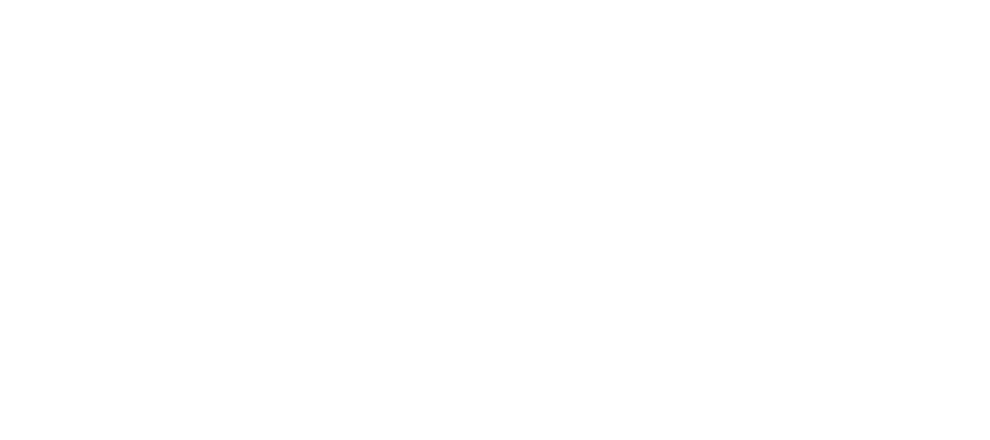

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [15]:
index = np.abs(s_ss).argmax(axis=0)
x,y,z,band= f_ss/1e9, s_ss,[],[]
for i in range(np.shape(s_ss)[1]):
    try:
        a,b,c,d,e = op.Lorentz_Fit().fitLorentz(x[:,i],np.abs(y[:,i]))
        z.append(a/(1.0+c*(x[:,i]-b)**2)+d)
        band.append((b,e))
    except:
        pass
z = np.array(z).T
f_rabi = np.array([x[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y),'-o',markersize=2)
# axes[0].plot(x,z)
axes[0].set_title(f'f={np.array(band)[:,0]}GHz')
print(band)
axes[1].plot(x,np.angle(y))
plt.show()

# spec2d

In [ ]:
dcch2.dc(0.35)
dcch4.dc(-0.35)

In [279]:
await att6.set_att(0)

In [296]:
freq = np.arange(3.3,4.2,0.001)*1e9
# await att6.set_att(0)
current = np.linspace(-0.2,0.2,41)
job = Job(ezQ.spec2d, (q_target,measure,freq,current), tags=[q_target.q_name], max=len(current))
v_s2, f_s2, s_s2 = await job.done()
measure.dc[q_target.q_name].dc(0)

Output()

In [12]:
freq = np.arange(3.3,4.2,0.001)*1e9
current = [0]*1000
job = Job(ezQ.spec2d, (q_target,measure,freq,current), tags=[q_target.q_name], max=len(current))
v_s2, f_s2, s_s2 = await job.done()
measure.dc[q_target.q_name].dc(0)

Output()

# spec2d_zpulse

In [13]:
q_target=q6
freq = np.arange(3.3,4.2,0.001)*1e9
current = np.linspace(-20e3,20e3,101)
job = Job(ezQ.spec2d_zpulse, (q_target,measure,freq,current,True), tags=[q_target.q_name], max=len(current))
v_s2, f_s2, s_s2 = await job.done()
measure.dc[q_target.q_name].dc(0)

Output()

# Rabi

In [203]:
await measure.psg['psg_lo'].setValue('Frequency',(6.56844e9-80e6))

In [23]:
q_target = q5
readpoint = readponit

t_rabi = np.linspace(1,201,201)
tag = q_target.q_name
await measure.psg['psg_ex'].setValue('Power',24)
# await att6.set_att(0)
await measure.psg['psg_lo'].setValue('Output','ON')
# await measure.psg['psg_lo'].setValue('Frequency',f_lo)
await measure.psg['psg_ex'].setValue('Frequency',(q_target.f_ex-q_target.delta_ex)[0])
job = Job(sim.Rabi, (q_target,measure,readpoint,f_ex[0],t_rabi), tags=[tag], max=len(t_rabi))
t_r, s_r = await job.done()

NameError: name 'readponit' is not defined

In [43]:
f_ex

array([3.884e+09])

In [39]:
q_target.delta_ex

array([2.e+08])

<IPython.core.display.Javascript object>


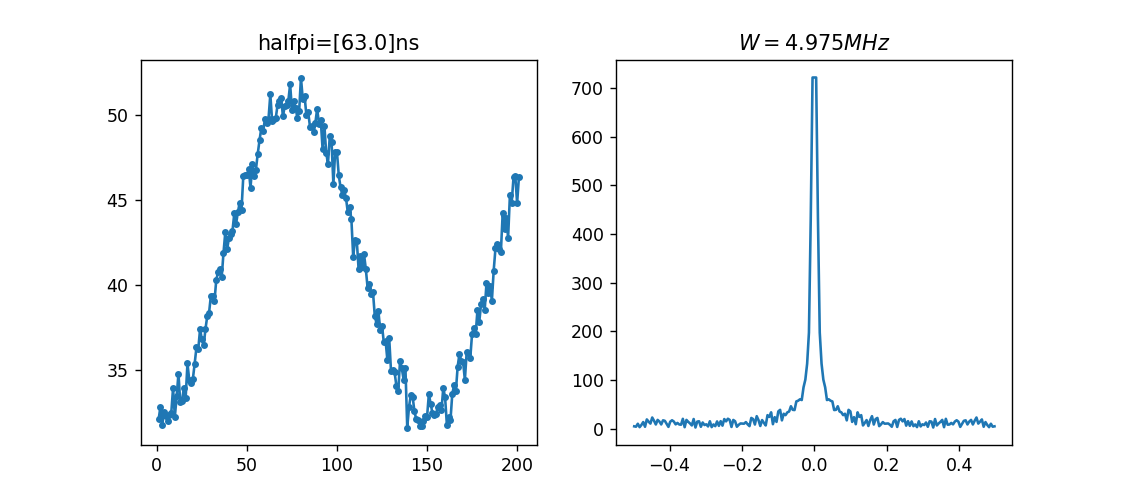

In [45]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
# axes[0].plot(t_r[:,0],np.abs(s_r[:,0]),'.',markersize=2)
# axes[0].plot(x,z)
# axes[0].set_title(f'f={np.array(band)[:,0]}GHz')
#print(band)
t_op = []
x, y = t_r[:,0], np.abs(s_r)
t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))

w,yt,amp = op.RowToRipe().fourier(x,y)
axes[0].plot(x,y,'-o',markersize=3)
axes[0].set_title(f'halfpi={t_op}ns')
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
axes[1].set_title('$W=%.3fMHz$'%(w*1000))
plt.show()

<IPython.core.display.Javascript object>


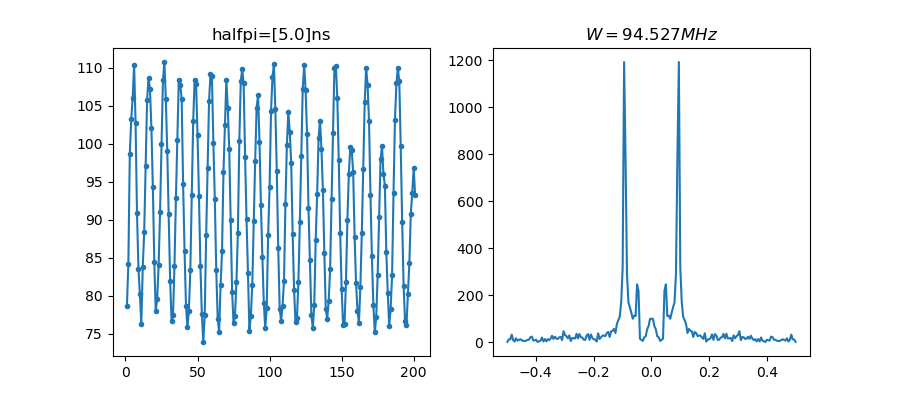

In [266]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
# axes[0].plot(t_r[:,0],np.abs(s_r[:,0]),'.',markersize=2)
# axes[0].plot(x,z)
# axes[0].set_title(f'f={np.array(band)[:,0]}GHz')
#print(band)
t_op = []
x, y = t_r[:,0], np.abs(s_r)
t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))

w,yt,amp = op.RowToRipe().fourier(x,y)
axes[0].plot(x,y,'-o',markersize=3)
axes[0].set_title(f'halfpi={t_op}ns')
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
axes[1].set_title('$W=%.3fMHz$'%(w*1000))
plt.show()

In [265]:
t_op[0]

5.0

In [305]:
q6 = q6._replace(pi_len = 10)

In [ ]:
index = np.abs(s_r).argmax(axis=0)
t_op = np.array([t_r[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
t_op = []
for i in range(np.shape(s_r)[1]):
    x, y = t_r[:,i], np.abs(s_r[:,i])
    t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))
    w,yt,amp = op.RowToRipe().fourier(x,y)
    axes[0].plot(x,y,'-o',markersize=3)
    axes[0].set_title(f'halfpi={t_op}ns')
    axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
    axes[1].set_title('$W=%.3fMHz$'%(w*1000))
    plt.show()

# RabiPower

In [148]:
await measure.psg['psg_ex'].setValue('Power',23)

In [371]:
q6 = q6._replace(pi_len = 10)

In [339]:
q_target = q6
power = np.linspace(100,32000,101)
tag = q_target.q_name
# await measure.psg['psg_ex'].setValue('Power',18)
# await att6.set_att(0)
await measure.psg['psg_lo'].setValue('Output','ON')
# await measure.psg['psg_lo'].setValue('Frequency',f_lo)
await measure.psg['psg_ex'].setValue('Frequency',(q_target.f_ex-q_target.delta_ex)[0])
job = Job(sim.RabiPower, (q_target,measure,readpoint,f_ex,power), tags=[tag], max=len(t_rabi))
t_rp, s_rp = await job.done()

Output()

<IPython.core.display.Javascript object>


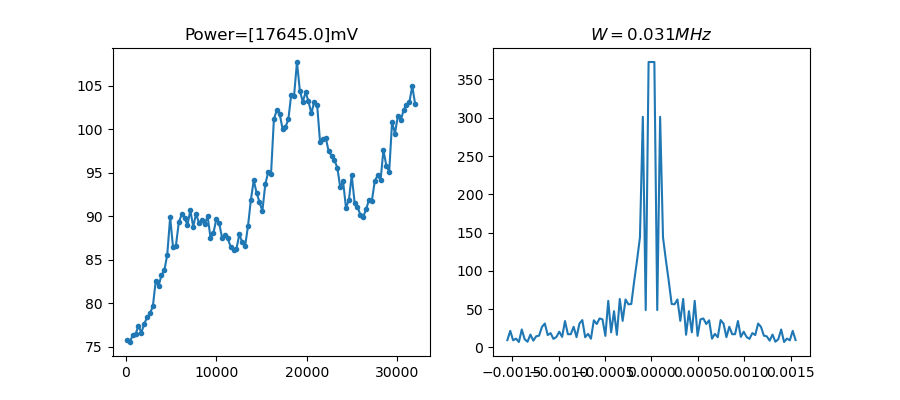

In [340]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
# axes[0].plot(t_r[:,0],np.abs(s_r[:,0]),'.',markersize=2)
# axes[0].plot(x,z)
# axes[0].set_title(f'f={np.array(band)[:,0]}GHz')
#print(band)
t_op = []
x, y = t_rp[:,0], np.abs(s_rp[:,0])
t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))
w,yt,amp = op.RowToRipe().fourier(x,y)
axes[0].plot(x,y,'-o',markersize=3)
axes[0].set_title(f'Power={t_op}mV')
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
axes[1].set_title('$W=%.3fMHz$'%(w*1000))
plt.show()

In [372]:
q6.pi_len

10

In [373]:
cw.rabiWave(q_target, measure, envelopename='cospulse',nwave=1,during=q_target.pi_len/1e9,Delta_lo=200e6,amp=24e3)

0 2e-08 89860.0


(<qulab.waveform.Waveform at 0x2a4ba03bfc8>,
 <qulab.waveform.Waveform at 0x2a4ba03f488>)

# 优化读出点

In [73]:
q_target.f_lo[0]

6569000000.0

In [63]:
# freq = np.linspace(-1,1,126)+q_target.f_lo
job = Job(ezQ.readOptest, (qubit,measure,False,None), tags=[tag], max=2)
st, f_op, s_op = await job.done()

Output()

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
f_lo = []
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
for i in range(measure.n):
    f, s_off, s_on = f_op[:,:,i][0], s_op[:,:,i][0], s_op[:,:,i][1]
    f_lo1 = (f[np.argmin(np.abs(s_off))] + f[np.argmin(np.abs(s_on))])/2
    x_off, y_off = op.RowToRipe().deductPhase(f,s_off)
    x_on, y_on = op.RowToRipe().deductPhase(f,s_on)
    anglediff = (np.angle(y_off[0])-np.angle(y_on[0]))
    index = np.abs(anglediff).argmax(axis=0)
    #index = np.abs(s_off).argmin(axis=0)
    f_lo.append(f[index] if np.abs(f[index]-f_lo1)<0.1e6 else f_lo1)
    axes[0].plot(f_op[:,:,i].T,np.abs(s_op[:,:,i].T))
    axes[0].vlines(f_lo,np.max(np.abs(s_op[:,:,i].T)),np.min(np.abs(s_op[:,:,i].T)),'r')
    axes[1].plot(x_off,np.angle(y_off[0]))
    axes[1].plot(x_on,np.angle(y_on[0]))
    axes[1].plot(x_off,anglediff)
    axes[1].vlines(f_lo,np.max(anglediff),np.min(np.angle(y_off[0])),'r')
plt.show()
f_lo, delta, n = await mr.resn(np.array(f_lo))
axes[0].set_title(f'fread={f_lo-50e6}')
measure.f_lo, measure.delta, measure.n = f_lo, delta, n
await psg['psg_lo'].setValue('Frequency',f_lo)

In [129]:
q6.amp

AttributeError: 'qubit' object has no attribute 'amp'

# T1

In [48]:
q_target = q5
amp=24e3
t_T1 = np.linspace(0,160000,401)
# await psg_ex1.setValue('Moutput','OFF')
job = Job(sim.T1, (q_target,measure,readponit, f_ex, t_T1, q_target.pi_len,amp), tags=[tag], max=len(t_T1))
t_t, s_t = await job.done()
# A, B, T1 = op.Exp_Fit().fitExp(t_t[:,0],np.abs(s_t[:,0]))
# z = A * np.exp(-t_t[:,0]*T1) + B

Output()

d:\qulab\qulab\optimize.py:129: RuntimeWarning: overflow encountered in exp
  return np.sum((A * np.exp(-x*T1) + B - y)**2)
d:\qulab\qulab\optimize.py:129: RuntimeWarning: overflow encountered in square
  return np.sum((A * np.exp(-x*T1) + B - y)**2)
C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\scipy\optimize\optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
d:\qulab\qulab\optimize.py:129: RuntimeWarning: overflow encountered in multiply
  return np.sum((A * np.exp(-x*T1) + B - y)**2)


<IPython.core.display.Javascript object>


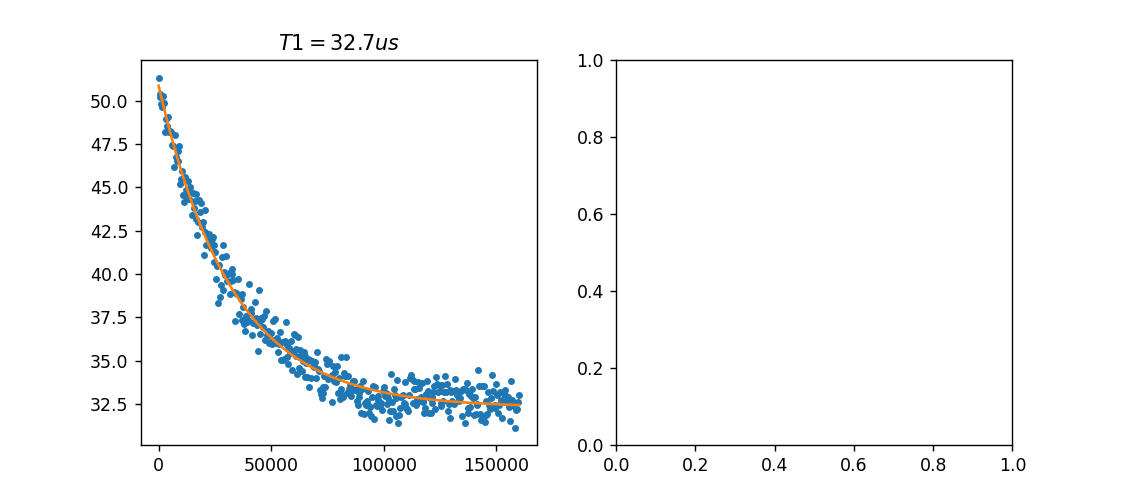

In [49]:
A, B, T1 = op.Exp_Fit().fitExp(t_t[:,0],np.abs(s_t))
z = A * np.exp(-t_t[:,0]*T1) + B
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_t[:,0],np.abs(s_t),'.')
axes[0].plot(t_t[:,0],z)
axes[0].set_title('$T1=%.1fus$'%(1/T1/1000))
# axes[1].plot(t_t,np.angle(s_t))
plt.show()

# Ramsey

In [50]:
q_target = q5
amp=24000 ###激励电压
# await measure.psg['psg_ex'].setValue('Frequency',(q_target.f_ex-q_target.delta_ex)[0])
t_T1= np.linspace(1,10001,201)
# await psg_ex1.setValue('Moutput','OFF')
job = Job(sim.Ramsey, (q_target,measure,readpoint, f_ex,t_T1,q_target.pi_len,amp), tags=[tag], max=len(t_T1))
t_t1, s_t1 = await job.done()
# A, B, T1 = op.Exp_Fit().fitExp(t_t[:,0],np.abs(s_t[:,0]))
# z = A * np.exp(-t_t[:,0]*T1) + B

Output()

In [294]:
for i in range(100): 
    await psg_ex.query('syst:err?')

In [295]:
await psg_lo.query('syst:err?')

'0,"No error"\r\n'

<IPython.core.display.Javascript object>


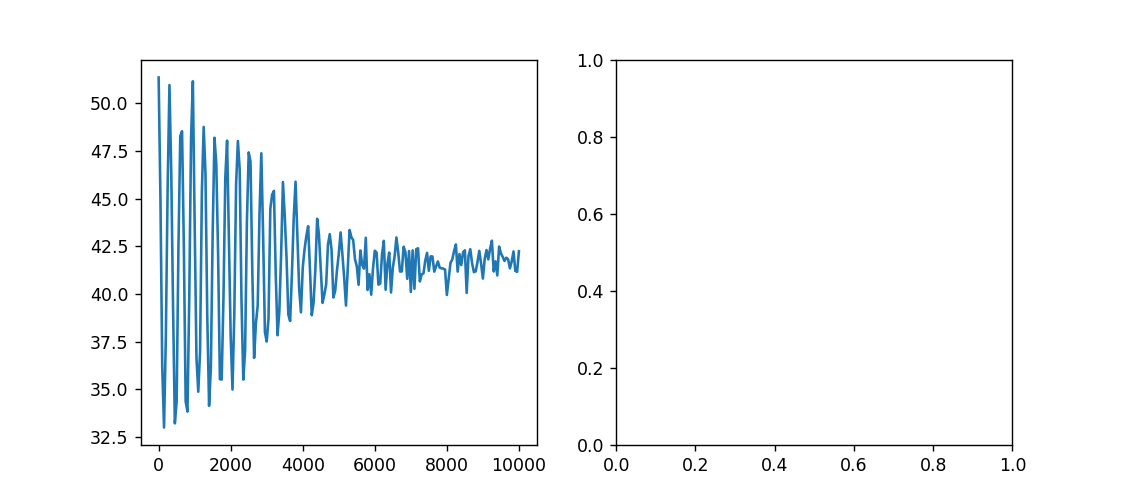

In [51]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_t1[:,0],np.abs(s_t1[:,0]),'-')
# axes[1].plot(t_t,np.angle(s_t))
plt.show()

In [378]:
fig = plt.gcf()
ax = plt.getp(fig,'axes')
num = 1
for i in range(num):
    x, y  = t_t1[:,0], s_t1[:,0]
    sample = (np.max(x) - np.min(x))/(len(x) - 1)
    yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
    amp = np.fft.fftshift(np.fft.fft(y))
    A,B,T1,T2,w,phi,out = op.T2_Fit(funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
    z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
    z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
    env = out[0]*np.exp(-(x/out[3])**2-x/out[2]/2)+out[1]
    ax[i].plot(x,z)
    ax[i].plot(x,z_env)
#     ax[i].plot(x,out[-1])
#     ax[i].set_title('$T_{1}=%f,T_{2}=%f,w=%f$'%(T1,T2,w*1e3))
    ax[i].set_title('$T_{2}=%f,w=%f$'%(T2,w*1e3))
    #ax[i].set_title('$T_{2}=%f$'%T2)
    ax[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
    ax[i].set_xlabel('time / ns')
    ax[i].set_ylabel('Voltage / a.u.')
plt.show()

d:\qulab\qulab\optimize.py:126: RuntimeWarning: overflow encountered in exp
  return np.sum((A * np.exp(-T2*x**2-x*T1) + B - y)**2)
C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\scipy\optimize\optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
d:\qulab\qulab\optimize.py:126: RuntimeWarning: overflow encountered in square
  return np.sum((A * np.exp(-T2*x**2-x*T1) + B - y)**2)


(11.31603298446764, 102.3223281984759, 35000, 1730.303964516725, 0.007761194029850747, 0)


d:\qulab\qulab\optimize.py:255: RuntimeWarning: overflow encountered in exp
  return np.sum((A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B - y)**2)
d:\qulab\qulab\optimize.py:255: RuntimeWarning: overflow encountered in square
  return np.sum((A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B - y)**2)
d:\qulab\qulab\optimize.py:255: RuntimeWarning: overflow encountered in multiply
  return np.sum((A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B - y)**2)


# SpinEcho

In [52]:
q_target = q5
amp=24000
t_spin= np.linspace(0,10000,201)
# await measure.psg['psg_ex'].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(sim.SpinEcho, (q_target,measure,readpoint,f_ex,t_spin,q_target.pi_len,'CPMG',amp), tags=[tag], max=len(t_spin))
t_sp, s_sp = await job.done()

Output()

<IPython.core.display.Javascript object>


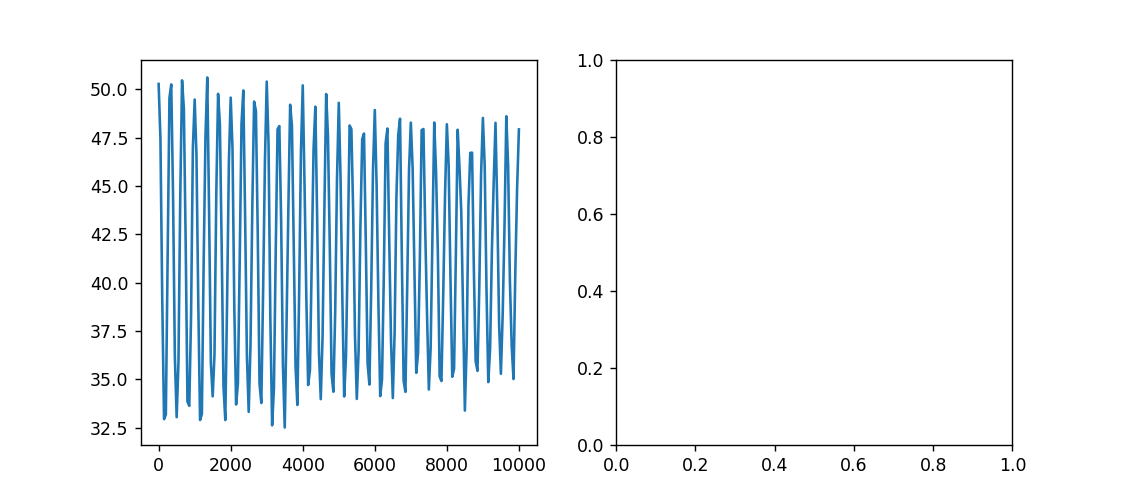

In [53]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_sp[:,0],np.abs(s_sp),'-')
# axes[1].plot(t_t,np.angle(s_t))
plt.show()


d:\qulab\qulab\optimize.py:126: RuntimeWarning: overflow encountered in exp
  return np.sum((A * np.exp(-T2*x**2-x*T1) + B - y)**2)
C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\scipy\optimize\optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


(9.053264405416314, 45.13574923520513, 20000, 52320.4022019447, 0.0029850746268656712, 0)


d:\qulab\qulab\optimize.py:255: RuntimeWarning: overflow encountered in square
  return np.sum((A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B - y)**2)
d:\qulab\qulab\optimize.py:255: RuntimeWarning: overflow encountered in exp
  return np.sum((A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B - y)**2)
d:\qulab\qulab\optimize.py:255: RuntimeWarning: overflow encountered in multiply
  return np.sum((A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B - y)**2)


<IPython.core.display.Javascript object>


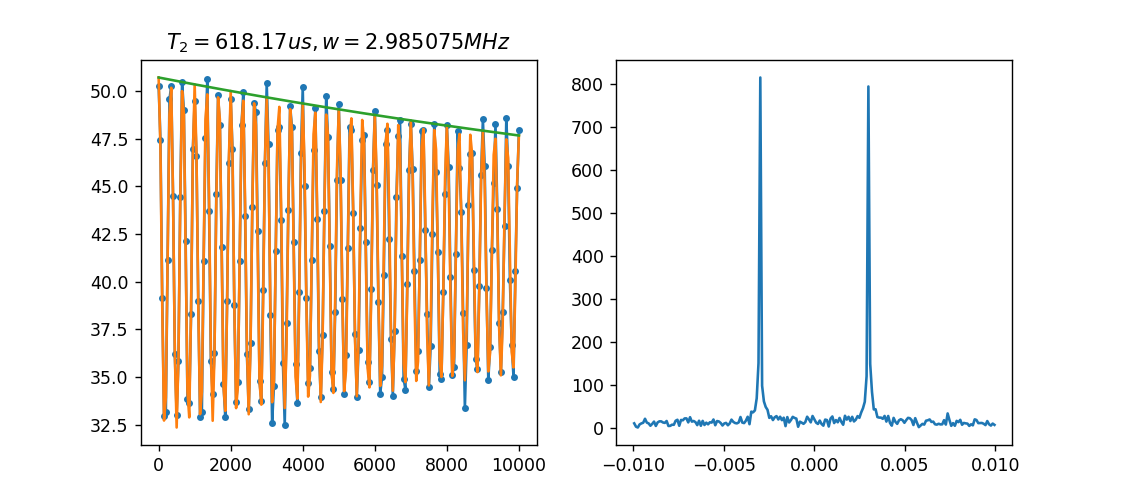

In [54]:
x, y = t_sp[:,0], s_sp
A,B,T1,T2,w,phi,out = op.T2_Fit(T1=20000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
w,yt,amp = op.RowToRipe().fourier(x,y)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y),'-o',markersize=3)
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{2}=%.2fus,w=%fMHz$'%(np.abs(T2/1000),w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

# readout frequency

In [274]:
async def Readout_F(qubit,measure,freq):
    await psg_pump.setValue('Output','ON')
    for i in freq:
        await psg_lo.setValue('Frequency',i)
        
        await psg_ex.setValue('Output','OFF')
        time.sleep(0.5)
        ch_A, ch_B = ezQ.getIQ(qubit,measure,fft=False,avg=False,hilbert=False,is2ch=False)
        Am, Bm = ch_A[:,0],ch_B[:,0]
#         print(Am)
#         theta0 = np.angle(Am) - np.angle(Bm)
#         ch_B *= np.exp(1j*theta0)
        s_on_0 = Am + 1j*Bm
        await psg_ex.setValue('Output','ON')
        time.sleep(0.5)
        ch_A, ch_B = ezQ.getIQ(qubit,measure,fft=False,avg=False,hilbert=False,is2ch=False)
        Am, Bm = ch_A[:,0],ch_B[:,0]
#         theta0 = np.angle(Am) - np.angle(Bm)
#         ch_B *= np.exp(1j*theta0)
        s_on_1 = Am + 1j*Bm
        r0 ,r1 = np.mean(s_on_0) ,np.mean(s_on_1)
        sigma = np.abs(np.std(s_on_0))
        SNR = np.abs(r0-r1)**2/2/sigma**2
        yield [i], [SNR]

In [275]:
q_target = q6
freq, num = np.linspace(-2,2,401)*1e6+6.56822e9, n
await psg_lo.setValue('Output','ON')
await psg_ex.setValue('Output','OFF')
job = Job(Readout_F, (q_target,measure,freq), tags=[q_target.q_name], comment="1D_%d"%num, max=len(freq))
f_rr, SNR_rr = await job.done()

Output()

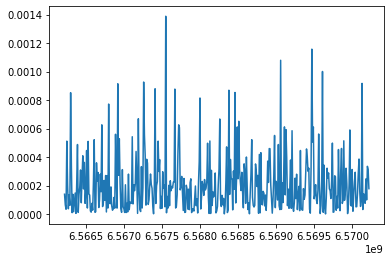

In [276]:
%matplotlib inline
index = np.abs(SNR_rr).argmax(axis=0)
f_op = np.array([f_rr[:,i][j] for i, j in enumerate(index)])
plt.plot(f_rr,abs(SNR_rr))
plt.show()

# 临界判断

In [117]:
depth1=1500
for i in measure.awg:
    measure.awg[i].da_trigg(5000, trig_interval, mode=0)
awg1.da_set_trig_delay(ad_trig_delay)#AWG主板
measure.ad.set_ad(depth1, 5000, mode=1)
measure.ad.set_ad_freq(f_mix, depth1, window_start=8)
measure.ad.ad_data_clear()

da board:[QF10K4N0050] set trig success .
da board:[QF10K4N0075] set trig success .
da board:[QF10K4N0064] set trig success .
da board:[QF10K4N0034] set trig success .
da board:[QE10K4N0016] set param success .


0

In [281]:
# await att3.set_att(21)
await psg['psg_lo'].setValue('Output','ON')
await measure.psg['psg_lo'].setValue('Frequency',(6.56822e9-80e6))

In [291]:
await att3.set_att(21.5)

In [292]:
q_target = q6
job = Job(ezQ.threshHold, (q_target,measure,t_op[0],False), tags=[q_target.q_name], max=2)
s_st, s_st_Q = await job.done()
num = measure.n//2+measure.n%2

Output()

<IPython.core.display.Javascript object>


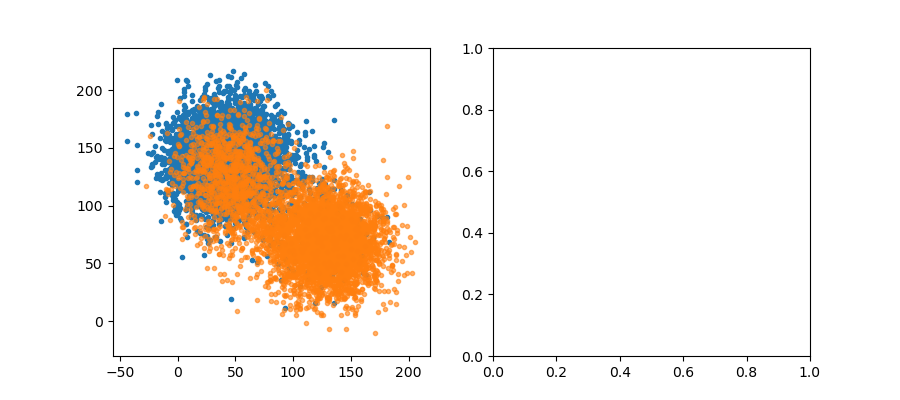

In [293]:
%matplotlib notebook
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st_Q[0,:,i], s_st_Q[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
#     ax.vlines([0],10,-100)
#     ax.hlines([0],-10,100)
    ax.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


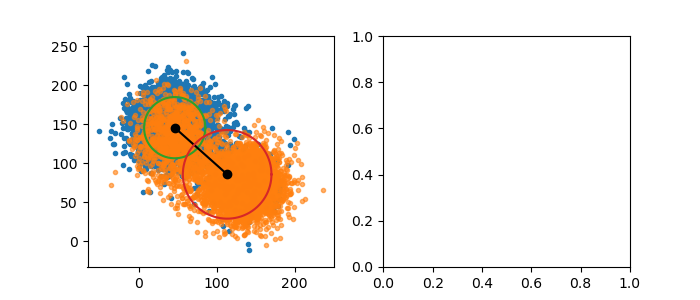

In [287]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(7,3*num))
for i in range(measure.n):
    s_off, s_on = s_st_Q[0,:,i], s_st_Q[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    x, y = s_off, s_on
    offmean, onmean = np.mean(x), np.mean(y)
    offstd, onstd = np.std(x), np.std(y)
    theta = np.arange(0, 2*np.pi, 0.01)
    roff = np.real(offmean) + offstd * np.cos(theta)
    ioff = np.imag(offmean) + offstd * np.sin(theta)
    ron = np.real(onmean) + onstd * np.cos(theta)
    ion = np.imag(onmean) + onstd * np.sin(theta)
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
    ax.axis('equal')
    ax.plot(roff,ioff)
    ax.plot([np.real(offmean),np.real(onmean)],[np.imag(offmean),np.imag(onmean)],'k-o')
    ax.plot(ron,ion)
plt.show()

In [127]:
measure.qubitToread=['q6']

<IPython.core.display.Javascript object>


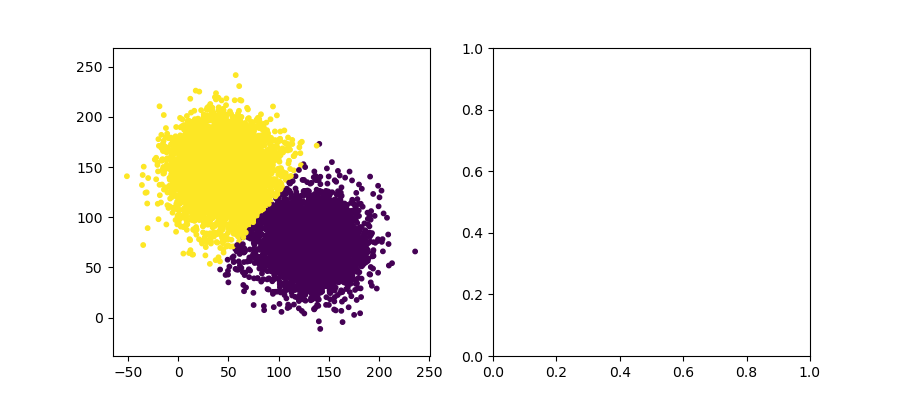

0.5942


In [288]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
predict = {}
for i in range(measure.n):
    s_off, s_on = s_st_Q[0,:,i], s_st_Q[1,:,i]
    S = list(s_off) + list(s_on)
    x,z = np.real(S), np.imag(S)
    d = list(zip(x,z))
    kmeans = KMeans(n_clusters=2,max_iter=100,tol=0.001)
    kmeans.fit(d)
    predict[measure.qubitToread[i]] = kmeans.predict
    y = kmeans.predict(d)
    print(list(y).count(1)/len(y))
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(x,z,c=y,s=10)
    ax.axis('equal')
plt.show()
measure.predict = predict

<IPython.core.display.Javascript object>


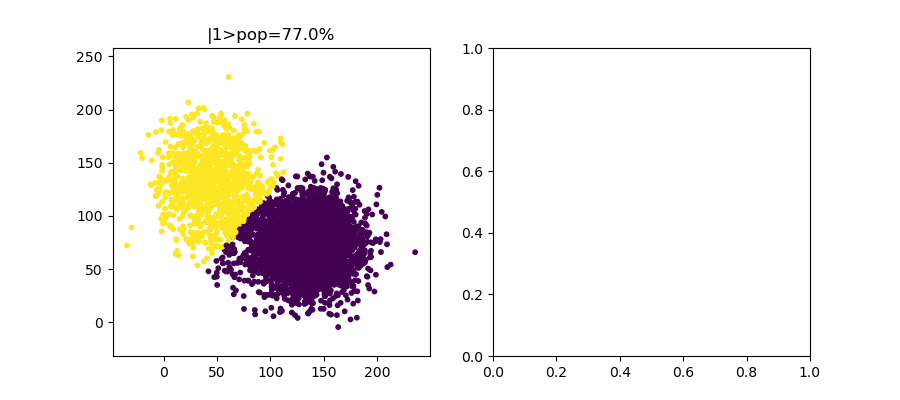

In [289]:
# sns.reset_orig()
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
onwhich, offwhich = [], []
for i in range(measure.n):
    s_off, s_on = s_st_Q[0,:,i], s_st_Q[1,:,i]
    ss, which = s_on, 0
    d = list(zip(np.real(ss),np.imag(ss)))
    y = measure.predict[measure.qubitToread[i]](d)
    percent1 = list(y).count(which)/len(y)
    onwhich.append(which if percent1 > 0.5 else 1-which)
    offwhich.append(1-which if percent1 > 0.5 else which)
    percent = list(y).count(onwhich[i])/len(y)
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(np.real(ss),np.imag(ss),c=y,s=10)
    ax.set_title(f'|1>pop={round(percent*100,3)}%')
    ax.axis('equal')
plt.show()
measure.onwhich = onwhich
measure.offwhich = offwhich

<IPython.core.display.Javascript object>


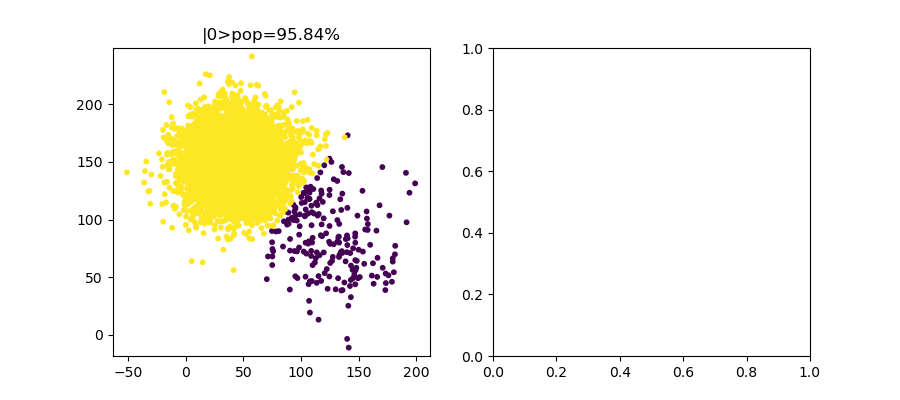

In [290]:
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st_Q[0,:,i], s_st_Q[1,:,i]
    ss, which = s_off, measure.offwhich[i]
    d = list(zip(np.real(ss),np.imag(ss)))
    y = measure.predict[measure.qubitToread[i]](d)
    percent = list(y).count(which)/len(y)
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(np.real(ss),np.imag(ss),c=y,s=10)
    ax.set_title(f'|0>pop={round(percent*100,3)}%')
    ax.axis('equal')
plt.show()

# tomo

In [358]:
q_target, which = q6, measure.onwhich
dragcoef = None
t_rabi = np.linspace(1,61,61)
amp = 25.2e3
# await psg['psg_ex'].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(ezQ.tomo, (q_target,measure,t_rabi,which), tags=[q_target.q_name], max=len(t_rabi))
t_tomo, poplist = await job.done()

Output()

In [359]:
save('tomo_test',tag,row=t_tomo,col=poplist,s=None,tags=tag,comment="1D_%d"%num)

WindowsPath('D:/QuLabData/2020/0818/tomo_test_20200818005952.npz')

# 关闭仪器

In [345]:
dcch1.dc(0)
dcch2.dc(0)
dcch3.dc(0)
dcch4.dc(0)
await psg['psg_lo'].setValue('Output','OFF')
await psg['psg_ex'].setValue('Output','OFF')

In [6]:
dcch2.dc(0.1)
dcch3.dc(0.1)
dcch4.dc(0.1)

In [122]:
dcch1.dc_query()
dcch2.dc_query()
dcch3.dc_query()
dcch4.dc_query()

dc:[DC1] query volt value:[6.675726581306662e-06].
dc:[DC1] query volt value:[6.675726581306662e-06].
dc:[DC1] query volt value:[6.675726581306662e-06].
dc:[DC1] query volt value:[6.675726581306662e-06].


6.675726581306662e-06

In [16]:
x = [0.09999570846148309*100]*60

<IPython.core.display.Javascript object>


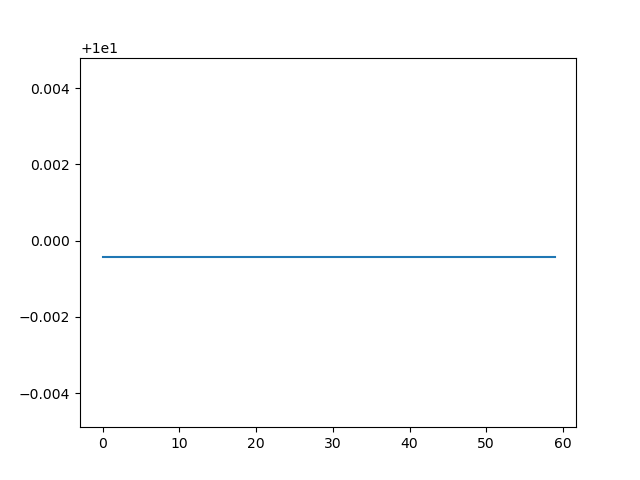

In [18]:
%matplotlib notebook
plt.figure()
plt.plot(range(60),x)

In [4]:
await psg_lo.query('syst:err?')

'0,"No error"\r\n'

## JPA

In [122]:
dcch1.dc(-0.43)
await psg_pump.setValue('Power',24.1)
await psg_pump.setValue('Frequency',2*6.58e9+2e6)
await psg_pump.setValue('Output','ON')

In [9]:
dcch1.dc(0)
await psg_pump.setValue('Output','OFF')

In [27]:
import visa
rm = visa.ResourceManager()
ins = rm.open_resource('TCPIP::10.0.200.28')

In [28]:
ins.write(':POWER 20dBm' )

(14, <StatusCode.success: 0>)